In [2]:
!pip install ultralytics

In [3]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 1.2 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 2.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 4.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [4]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=93f979c12c2e1673ce929f907c73960cc77f3b330f7a272021b24fb959f64f8d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [5]:
import numpy as np
import pandas as pd
import os

import random

import torch
import os
from IPython.display import Image, clear_output

import glob 
import cv2 
from PIL import Image
import yaml

import wget
import zipfile
import os

from matplotlib import pyplot as plt

from PIL import ImageDraw

from ultralytics import YOLO

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.1.2 (Tesla T4)


In [5]:
#url = 'https://www.dropbox.com/s/qvglw8pqo16769f/pothole_dataset_v8.zip?dl=1'
#filename = wget.download(url)

In [6]:
#with zipfile.ZipFile("pothole_dataset_v8.zip", 'r') as zip_ref:
#    zip_ref.extractall("dataset")                       

In [7]:
#os.remove("pothole_dataset_v8.zip")

In [26]:
class Config:
    INPUT_PATH = '/kaggle/input'
    OUTPUT_PATH = '/kaggle/working'
    DATASET_NAME = 'potholes-detection-roboflow'
    TRAINING_IMAGES_PATH = f'{INPUT_PATH}/{DATASET_NAME}/train/images/'
    LABELS_TRAINING_PATH =  f'{INPUT_PATH}/{DATASET_NAME}/train/labels/'
    TESTING_IMAGES_PATH = f'{INPUT_PATH}/{DATASET_NAME}/test/images'
    YAML_PATH =  f'{INPUT_PATH}/{DATASET_NAME}/data.yaml'

In [27]:
print(f'DATASET_NAME = {Config.DATASET_NAME}')
print(f'DATASET_PATH = {Config.OUTPUT_PATH}/{Config.DATASET_NAME}')
print(f'TRAINING_IMAGES_PATH = {Config.TRAINING_IMAGES_PATH}')
print(f'LABELS_TRAINING_PATH = {Config.LABELS_TRAINING_PATH}')
print(f'YAML_PATH = {Config.YAML_PATH}')

DATASET_NAME = potholes-detection-roboflow
DATASET_PATH = /kaggle/working/potholes-detection-roboflow
TRAINING_IMAGES_PATH = /kaggle/input/potholes-detection-roboflow/train/images/
LABELS_TRAINING_PATH = /kaggle/input/potholes-detection-roboflow/train/labels/
YAML_PATH = /kaggle/input/potholes-detection-roboflow/data.yaml


In [28]:
class Utils:
    @staticmethod
    def load_images(folder):
        images = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            images.append(img)
        return images
    
    
    @staticmethod
    def load_labels(folder):
        labels = []
        for filename in os.listdir(folder):
            if filename.endswith(".txt"):
                label_path = os.path.join(folder, filename)
                with open(label_path, 'r') as label_file:
                    label_data = []
                    for line in label_file:
                        label_info = list(map(float, line.strip().split()))
                        label_data.append(label_info)
                labels.append(label_data)
        return labels
    
    
    @staticmethod
    def load_classes(yaml_path):
        with open(yaml_path, 'r') as yaml_file:
            config = yaml.safe_load(yaml_file)
            class_names = config['names']
        return class_names
    
    
    @staticmethod
    def plot_random_images(images, rows, cols):
        num_images = rows * cols
        i = 0
        j = 0
        fig, axes = plt.subplots(rows, cols, figsize=((rows * rows), cols))
        for image in images:
            axes[i, j].imshow(image)
            axes[i, j].axis('off')
            j = j + 1
            if j == cols:
                j = 0
                i = i + 1
            if i == rows:
                break
        plt.tight_layout()
        plt.show()

img_shape = (416, 416, 3)
label_example = [[0.0, 0.5072115384615384, 0.7427884615384616, 0.20552884615384615, 0.12620192307692307], [0.0, 0.13822115384615385, 0.6394230769230769, 0.2620192307692308, 0.12620192307692307], [0.0, 0.6298076923076923, 0.5600961538461539, 0.2548076923076923, 0.0733173076923077], [0.0, 0.8401442307692307, 0.6550480769230769, 0.11538461538461539, 0.056490384615384616], [0.0, 0.40625, 0.43028846153846156, 0.13221153846153846, 0.039663461538461536]]
classes = ['pothole']


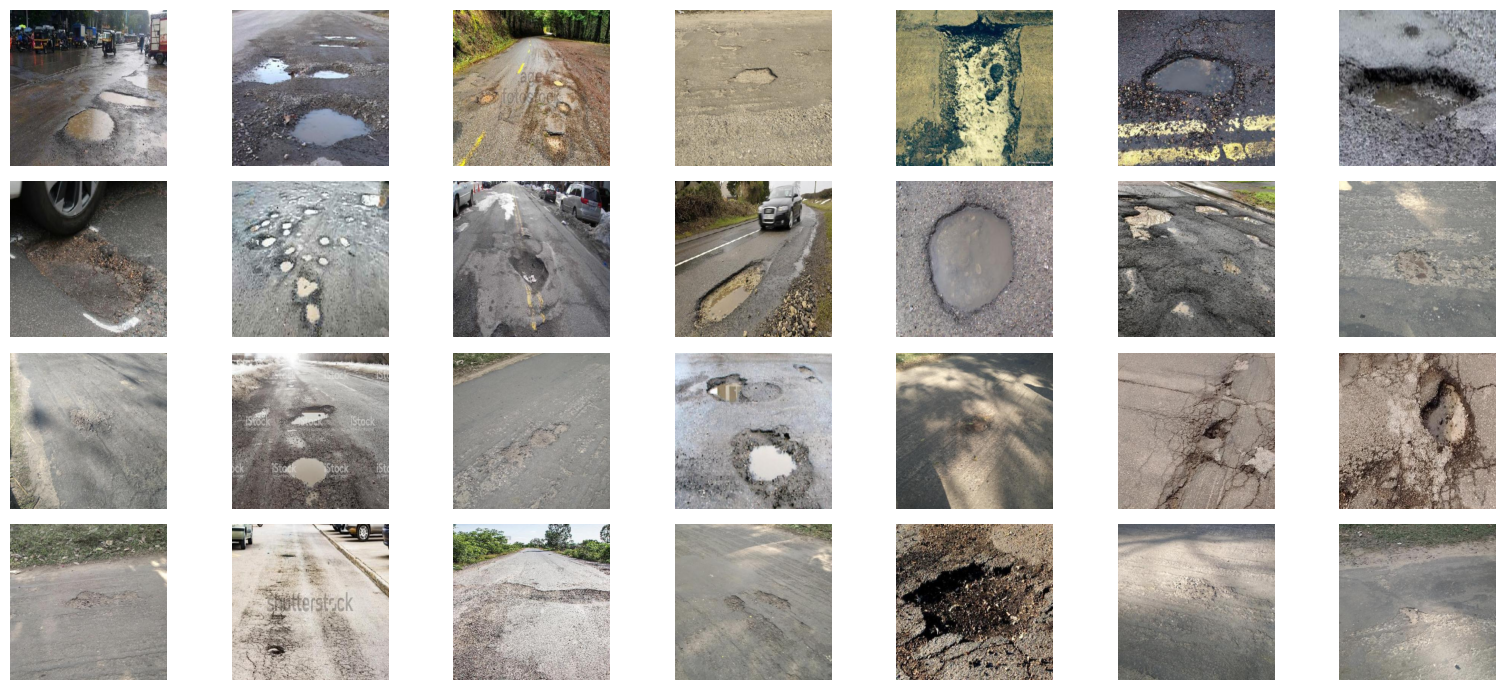

In [29]:
training_images = Utils.load_images(Config.TRAINING_IMAGES_PATH)
training_labels = Utils.load_labels(Config.LABELS_TRAINING_PATH)
classes = Utils.load_classes(Config.YAML_PATH)

img_example = np.array(training_images[0])
img_example = cv2.cvtColor(img_example, cv2.COLOR_RGB2BGR)
img_shape = img_example.shape
print(f'img_shape = {img_shape}')

label_example = training_labels[0]
print(f'label_example = {label_example}')

print(f'classes = {classes}')

# plotting random training images
Utils.plot_random_images(
    training_images,
    4,
    7
)

In [30]:
yolo_version = 'yolov8n.pt'
model = YOLO(yolo_version)
print(model)

100%|██████████| 6.23M/6.23M [00:00<00:00, 73.6MB/s]


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [31]:
model.train(
    data = Config.YAML_PATH,
    epochs = 50,
    imgsz = img_example.shape[0],
    device = 0,
    batch=8
)

Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/input/potholes-detection-roboflow/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

100%|██████████| 755k/755k [00:00<00:00, 14.1MB/s]
2024-04-22 14:06:14.522062: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 14:06:14.522169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 14:06:14.682419: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/input/potholes-detection-roboflow/train/labels... 465 images, 0 backgrounds, 0 corrupt: 100%|██████████| 465/465 [00:00<00:00, 933.30it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/potholes-detection-roboflow/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/potholes-detection-roboflow/valid/labels... 133 images, 0 backgrounds, 0 corrupt: 100%|██████████| 133/133 [00:00<00:00, 321.58it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/potholes-detection-roboflow/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.719G      1.731      2.564      1.525          1        416: 100%|██████████| 59/59 [00:09<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]

                   all        133        361      0.695      0.082      0.224      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.648G      1.639      1.887      1.468          3        416: 100%|██████████| 59/59 [00:05<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.09it/s]

                   all        133        361      0.359      0.341      0.242      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.648G       1.67      1.977      1.474          0        416: 100%|██████████| 59/59 [00:05<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.42it/s]

                   all        133        361      0.216       0.38      0.147     0.0635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.648G      1.709      1.878      1.505          2        416: 100%|██████████| 59/59 [00:05<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.14it/s]

                   all        133        361      0.323       0.33       0.24      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.648G      1.676      1.745      1.497          5        416: 100%|██████████| 59/59 [00:05<00:00, 11.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 10.93it/s]

                   all        133        361      0.572      0.468      0.489      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.648G      1.673      1.837      1.473          1        416: 100%|██████████| 59/59 [00:05<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.79it/s]

                   all        133        361      0.524       0.44      0.443      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.646G      1.594      1.613      1.431          6        416: 100%|██████████| 59/59 [00:05<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.83it/s]

                   all        133        361       0.61      0.535      0.551      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.646G      1.568      1.592      1.421          4        416: 100%|██████████| 59/59 [00:05<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 10.77it/s]

                   all        133        361      0.575      0.488      0.514      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.646G      1.581      1.532      1.431          4        416: 100%|██████████| 59/59 [00:05<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.48it/s]

                   all        133        361      0.618      0.474      0.542      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.648G      1.556      1.536      1.409          1        416: 100%|██████████| 59/59 [00:04<00:00, 11.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.47it/s]

                   all        133        361      0.653      0.573      0.617      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      0.64G      1.484      1.455      1.354          1        416: 100%|██████████| 59/59 [00:04<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.22it/s]

                   all        133        361       0.69      0.585      0.655      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.646G      1.535       1.46       1.38          8        416: 100%|██████████| 59/59 [00:04<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.18it/s]

                   all        133        361       0.61      0.584      0.606      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.646G      1.493       1.44      1.378          1        416: 100%|██████████| 59/59 [00:05<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.16it/s]

                   all        133        361      0.688       0.59      0.663      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.646G        1.5      1.406       1.39          6        416: 100%|██████████| 59/59 [00:04<00:00, 11.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.12it/s]

                   all        133        361       0.67      0.593      0.663       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.646G      1.462      1.399      1.367          2        416: 100%|██████████| 59/59 [00:05<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.18it/s]

                   all        133        361      0.688      0.569      0.659      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.646G      1.466      1.377      1.364          3        416: 100%|██████████| 59/59 [00:04<00:00, 11.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.05it/s]

                   all        133        361      0.788      0.535       0.68      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.646G      1.426      1.428      1.332          1        416: 100%|██████████| 59/59 [00:05<00:00, 11.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.84it/s]

                   all        133        361      0.697      0.596      0.685       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.648G      1.425      1.324      1.336         18        416: 100%|██████████| 59/59 [00:05<00:00, 11.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.98it/s]

                   all        133        361       0.68      0.629      0.698      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.638G      1.373      1.257      1.307          3        416: 100%|██████████| 59/59 [00:05<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.17it/s]

                   all        133        361      0.718      0.593      0.687      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.646G      1.375      1.243      1.314          6        416: 100%|██████████| 59/59 [00:04<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.10it/s]

                   all        133        361       0.72      0.585      0.696      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.646G      1.367      1.241      1.275          7        416: 100%|██████████| 59/59 [00:04<00:00, 11.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.30it/s]

                   all        133        361      0.748      0.657      0.726      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.648G      1.404      1.272      1.306          1        416: 100%|██████████| 59/59 [00:05<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.55it/s]

                   all        133        361      0.717      0.631      0.709      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.646G      1.377      1.179      1.282          3        416: 100%|██████████| 59/59 [00:04<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.10it/s]

                   all        133        361      0.745      0.618      0.722      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.646G      1.371      1.174      1.269         10        416: 100%|██████████| 59/59 [00:04<00:00, 12.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.83it/s]

                   all        133        361       0.71      0.659       0.71      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.646G      1.349      1.174      1.286          1        416: 100%|██████████| 59/59 [00:05<00:00, 11.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.60it/s]

                   all        133        361      0.734      0.657      0.723      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.646G       1.33      1.155      1.267          1        416: 100%|██████████| 59/59 [00:04<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.84it/s]

                   all        133        361        0.8       0.64      0.755       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.638G      1.316      1.165      1.265          2        416: 100%|██████████| 59/59 [00:05<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.90it/s]

                   all        133        361      0.747      0.648      0.732      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.646G      1.347      1.111      1.272          5        416: 100%|██████████| 59/59 [00:04<00:00, 11.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.38it/s]

                   all        133        361      0.783      0.634      0.743       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.646G        1.3      1.116      1.253          2        416: 100%|██████████| 59/59 [00:04<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.29it/s]

                   all        133        361      0.739      0.681       0.74      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.646G      1.307      1.142      1.249         10        416: 100%|██████████| 59/59 [00:04<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.64it/s]

                   all        133        361      0.798      0.662      0.757      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.646G      1.292      1.088       1.25          1        416: 100%|██████████| 59/59 [00:04<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 10.79it/s]

                   all        133        361      0.763      0.659      0.748      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.646G      1.288      1.083      1.262          2        416: 100%|██████████| 59/59 [00:04<00:00, 11.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.43it/s]

                   all        133        361      0.799      0.687      0.771      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.646G      1.251      1.066      1.237          1        416: 100%|██████████| 59/59 [00:05<00:00, 11.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.15it/s]

                   all        133        361      0.776      0.681      0.773      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.646G      1.214      1.028      1.205         10        416: 100%|██████████| 59/59 [00:05<00:00, 11.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.97it/s]

                   all        133        361      0.735      0.712      0.778      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.638G      1.229      1.017      1.208          5        416: 100%|██████████| 59/59 [00:04<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.02it/s]

                   all        133        361      0.864      0.645      0.778      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.646G       1.25       1.05      1.221          3        416: 100%|██████████| 59/59 [00:05<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.90it/s]

                   all        133        361      0.833      0.675      0.783      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.646G      1.234       1.02      1.225          1        416: 100%|██████████| 59/59 [00:04<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.36it/s]

                   all        133        361      0.749      0.686      0.773      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.646G      1.226     0.9937      1.195          9        416: 100%|██████████| 59/59 [00:04<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.59it/s]

                   all        133        361      0.789      0.676      0.775      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.646G      1.264       1.02      1.221          3        416: 100%|██████████| 59/59 [00:04<00:00, 11.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.38it/s]

                   all        133        361      0.834      0.653      0.763      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.646G      1.193     0.9489      1.193          1        416: 100%|██████████| 59/59 [00:04<00:00, 11.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.08it/s]

                   all        133        361       0.78      0.718       0.79      0.475


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.646G      1.134     0.9807      1.143          3        416: 100%|██████████| 59/59 [00:05<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.54it/s]

                   all        133        361      0.803       0.69      0.773      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.646G      1.168     0.9817      1.165          6        416: 100%|██████████| 59/59 [00:04<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.24it/s]

                   all        133        361      0.809       0.67      0.788      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.638G      1.074     0.8656      1.102          2        416: 100%|██████████| 59/59 [00:04<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.69it/s]

                   all        133        361      0.831      0.668      0.785      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.646G      1.085     0.8751      1.109          7        416: 100%|██████████| 59/59 [00:04<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.93it/s]

                   all        133        361      0.817      0.681      0.781       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.646G      1.062     0.8342       1.12          1        416: 100%|██████████| 59/59 [00:05<00:00, 11.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.66it/s]

                   all        133        361      0.828      0.668      0.786      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.646G      1.063     0.8138      1.112          3        416: 100%|██████████| 59/59 [00:04<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.84it/s]

                   all        133        361      0.818      0.717      0.796      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.646G      1.047     0.8274      1.094          3        416: 100%|██████████| 59/59 [00:04<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.55it/s]

                   all        133        361      0.793       0.72      0.799      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.646G      1.027     0.7843      1.083          1        416: 100%|██████████| 59/59 [00:04<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.93it/s]

                   all        133        361      0.822      0.693      0.797      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.646G      1.059     0.7895      1.101          2        416: 100%|██████████| 59/59 [00:04<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 11.75it/s]

                   all        133        361      0.849      0.684      0.799      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.646G      1.017     0.7578      1.068          1        416: 100%|██████████| 59/59 [00:05<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 12.67it/s]

                   all        133        361      0.854      0.676      0.804      0.506



50 epochs completed in 0.098 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]


                   all        133        361      0.854      0.679      0.804      0.505
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▂▂▁▂▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
metrics/mAP50-95(B),▂▂▁▂▃▄▄▅▆▅▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇██▇▇▇▇▇██████
metrics/precision(B),▆▃▁▂▄▅▅▅▆▅▆▆▇▆▆▇▇▆▇▆▇▇▇▇▇▇▇▇█▇▇█▇████▇██
metrics/recall(B),▁▄▄▄▅▆▅▅▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇█▇██████▇█▇▇█████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▇█▇▇▆▇▆▆▆▆▅▅▅▄▄▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fd6f5685c30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [32]:
model.export()

Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 5, 3549) (5.9 MB)

TorchScript: starting export with torch 2.1.2...
TorchScript: export success ✅ 1.6s, saved as 'runs/detect/train/weights/best.torchscript' (11.8 MB)

Export complete (1.8s)
Results saved to /kaggle/working/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.torchscript imgsz=416  
Validate:        yolo val task=detect model=runs/detect/train/weights/best.torchscript imgsz=416 data=/kaggle/input/potholes-detection-roboflow/data.yaml  
Visualize:       https://netron.app


'runs/detect/train/weights/best.torchscript'